In [1]:
%load_ext lab_black

In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

In [3]:
labels = {}
for i, row in pd.read_csv("data/train_labels.csv").iterrows():
    if row.label not in labels:
        labels[row.label] = row.label_desc
        # print(f"{row.label:02d}", row.label_desc)

In [4]:
for i in range(61):
    print(f"{i:02d}", labels[i])

00 Arm Band Adjustment
01 Band Pull-Down Row
02 Bicep Curl
03 Biceps Curl (band)
04 Burpee
05 Butterfly Sit-up
06 Chest Press (rack)
07 Crunch
08 Device on Table
09 Dip
10 Dumbbell Deadlift Row
11 Dumbbell Row (knee on bench) (label spans both arms)
12 Dumbbell Row (knee on bench) (left arm)
13 Dumbbell Row (knee on bench) (right arm)
14 Dumbbell Squat (hands at side)
15 Dynamic Stretch (at your own pace)
16 Elliptical machine
17 Fast Alternating Punches
18 Jump Rope
19 Jumping Jacks
20 Kettlebell Swing
21 Lateral Raise
22 Lawnmower (left arm)
23 Lawnmower (right arm)
24 Lunge (alternating both legs, weight optional)
25 Medicine Ball Slam
26 Non-Exercise
27 Overhead Triceps Extension
28 Plank
29 Power Boat pose
30 Pushup (knee or foot variation)
31 Pushups
32 Repetitive Stretching
33 Rowing machine
34 Running (treadmill)
35 Russian Twist
36 Seated Back Fly
37 Shoulder Press (dumbbell)
38 Side Plank Left side
39 Side Plank Right side
40 Sit-up (hands positioned behind head)
41 Sit-ups
4

# 데이터셋 만들기

In [5]:
train = pd.read_csv("data/train_features.csv")
test = pd.read_csv("data/test_features.csv")

In [6]:
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [7]:
test

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,3125,0,-0.628100,-0.160155,0.151487,49.665357,88.435961,13.597668
1,3125,1,-0.462548,0.012462,-0.053726,56.953059,96.185341,16.278458
2,3125,2,-0.363481,-0.091789,-0.130004,29.557396,93.836453,13.329043
3,3125,3,-0.351750,-0.239870,-0.193053,23.686172,88.608721,13.449771
4,3125,4,-0.312934,-0.123762,-0.318621,20.410071,85.327707,13.884912
...,...,...,...,...,...,...,...,...
469195,3906,595,0.104191,-0.784979,0.639513,-10.475346,14.095361,-190.358982
469196,3906,596,0.103297,-0.758954,0.615687,-25.360272,-8.523018,-180.393291
469197,3906,597,0.128294,-0.749389,0.586184,-27.917723,-23.186245,-162.624160
469198,3906,598,0.104130,-0.692731,0.573397,-27.847980,-30.407555,-138.761676


In [8]:
X = np.concatenate([train.to_numpy(), test.to_numpy()], axis=0)[:, 2:].T
X = torch.tensor(X, dtype=torch.float64)
X.shape

torch.Size([6, 2344200])

In [9]:
X = torch.stack(torch.split(X, 600, dim=1), dim=0)
X.shape

torch.Size([3907, 6, 600])

## Derived Variables

In [12]:
T1 = (X[:, :3] ** 2).sum(dim=1) ** (1 / 3)
T2 = (X[:, 3:] ** 2).sum(dim=1) ** (1 / 3)

In [13]:
T1 = (T1 - T1.mean()) / T1.std()
T2 = (T2 - T2.mean()) / T2.std()

In [14]:
X = torch.cat([X, T1.unsqueeze(1), T2.unsqueeze(1)], dim=1)
X.shape

torch.Size([3907, 8, 600])

## Velocity

In [54]:
V = [torch.zeros(X.shape[:2])]
for i in range(600):
    V.append(V[i] + X[..., i] * 0.02)

In [55]:
V = torch.stack(V[1:], dim=2)
V.shape

torch.Size([3907, 8, 600])

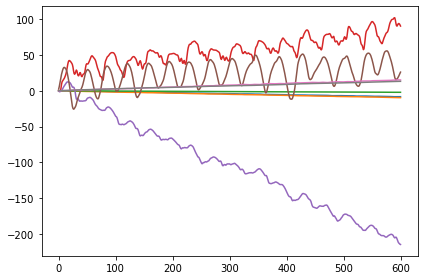

In [56]:
plt.plot(V[50, :].transpose(0, 1))
plt.tight_layout()
plt.show()

# Position

In [60]:
P = [torch.zeros(X.shape[:2])]
for i in range(600):
    P.append(P[i] + V[..., i] * 0.02)

In [61]:
P = torch.stack(P[1:], dim=2)
P.shape

torch.Size([3907, 8, 600])

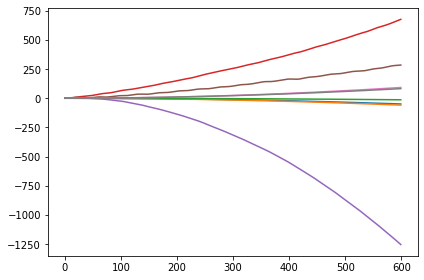

In [62]:
plt.plot(P[50, :].transpose(0, 1))
plt.tight_layout()
plt.show()

# Blur

In [77]:
@torch.no_grad()
def gaussian(x, ksize=5, sigma=1.0):
    k = cv2.getGaussianKernel(ksize, sigma)
    k = torch.tensor(k, dtype=torch.float64)
    k = torch.repeat_interleave(k, 8, dim=1)
    k.transpose_(0, 1)
    k.unsqueeze_(1)

    psize = ksize // 2
    return F.conv1d(x[:, :8], k, groups=8, padding=psize)

In [78]:
Xg = gaussian(X)

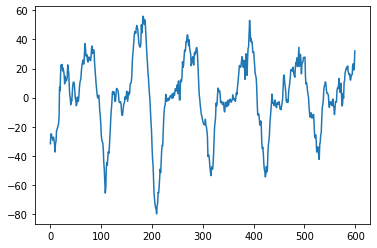

In [82]:
plt.plot(X[0, 5])

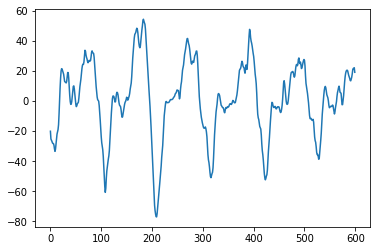

In [81]:
plt.plot(Xg[0, 5])

In [83]:
Xg.shape

torch.Size([3907, 8, 600])

## Standardization

In [84]:
X = torch.cat([X, V, P], dim=1)
Xg = torch.cat([Xg, V, P], dim=1)
X.shape, Xg.shape

(torch.Size([3907, 24, 600]), torch.Size([3907, 24, 600]))

In [86]:
Xstd = (X - X.mean(dim=[0, 2], keepdim=True)) / X.std(dim=[0, 2], keepdim=True)
Xstd.shape

torch.Size([3907, 24, 600])

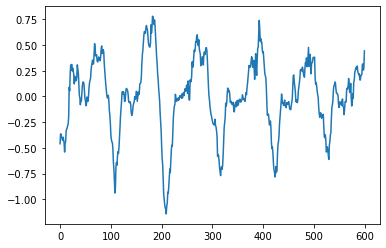

In [87]:
plt.plot(Xstd[0, 5])

In [88]:
Xgstd = (Xg - Xg.mean(dim=[0, 2], keepdim=True)) / Xg.std(dim=[0, 2], keepdim=True)
Xgstd.shape

torch.Size([3907, 24, 600])

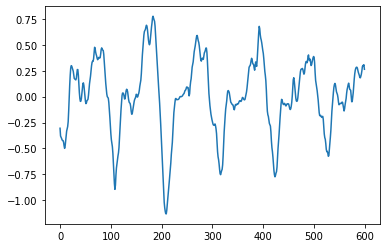

In [89]:
plt.plot(Xgstd[0, 5])

## Labeling

In [90]:
Y_train = pd.read_csv("data/train_labels.csv")

In [91]:
Y_train

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [92]:
Y_train = torch.tensor(Y_train["label"].to_numpy(), dtype=torch.long)

In [94]:
L = len(Y_train)
X_train = Xstd[:L]
Xg_train = Xgstd[:L]
X_test = Xstd[L:]
Xg_test = Xgstd[L:]

In [95]:
Y_train.shape, X_train.shape, Xg_train.shape, X_test.shape, Xg_test.shape

(torch.Size([3125]),
 torch.Size([3125, 24, 600]),
 torch.Size([3125, 24, 600]),
 torch.Size([782, 24, 600]),
 torch.Size([782, 24, 600]))

# Save as a file

In [96]:
np.savez_compressed("data/0222.npz", X_train=X_train, Y_train=Y_train, X_test=X_test)
np.savez_compressed(
    "data/0222_blur.npz", X_train=Xg_train, Y_train=Y_train, X_test=Xg_test
)